In [1]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import pandas as pd
import gensim
from gensim.models import CoherenceModel
from gensim import corpora
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
from importlib import reload
import warnings
from pprint import pprint
import string
import pyLDAvis.gensim as gensimvis
import pickle 
import pyLDAvis
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [2]:
warnings.filterwarnings("ignore")

In [3]:
import clean_tweets_dataframe as cld

In [4]:
reload(cld)

<module 'clean_tweets_dataframe' from 'C:\\Users\\Faith Bagire\\PycharmProjects\\pythonProject\\tweets_analyze\\clean_tweets_dataframe.py'>

In [7]:
# from clean_tweets_dataframe import CleanTweets

In [8]:
df_tweet=pd.read_csv("processed_tweet_data.csv")

In [9]:
cleaner=cld.CleanTweets(df_tweet)

Automation in Action...!!!


**Using cleaner module from clean_tweets_dataframe to clean the imported dataset**

In [10]:
df_tweet=cleaner.drop_unwanted_column(df_tweet)
df_tweet=cleaner.drop_duplicate(df_tweet)
df_tweet=cleaner.convert_to_datetime(df_tweet)
df_tweet=cleaner.convert_to_numbers(df_tweet)
df_tweet=cleaner.remove_non_english_tweets(df_tweet)

In [11]:
print(df_tweet.shape)
df_tweet.head()

(1300, 19)


,created_at,source,original_text,cleaned_text,polarity,subjectivity,sentiment,lang,favorite_count,retweet_count,original_author,followers_count,friends_count,possibly_sensitive,hashtags,retweet_hashtags,user_mentions,place,place_coord_boundaries
8,2022-07-18 15:25:28+00:00,Twitter for Android,RT @TheoMpoze: ‘It shouldn’t be happening agai...,‘It shouldn’t be happening again’: rebels ret...,-0.15,0.100000,Negative,en,0,0,Nduwamungu5,1579,418,False,PrimerasPáginas,NaN,EUwatchers,Valhalla,NaN
9,2022-07-18 15:21:48+00:00,EUwatch,European heat wave: Britain announces national...,European heat wave: Britain announces national...,0.00,0.000000,Neutral,en,0,0,EUwatchers,25730,7621,False,Dictator,NaN,RepDeFiFidonia,República de FiFidonia,NaN
12,2022-07-18 15:19:37+00:00,Twitter for Android,RT @EUwatchers: European heat wave: Britain an...,European heat wave: Britain announces national...,0.00,0.000000,Neutral,en,0,0,Zgur_,3903,4278,False,Dictator,NaN,"aqlila1, inksteadywp",República Amorosa de México,NaN
17,2022-07-18 15:14:41+00:00,Microsoft Power Platform,Why are weather forecasts not always accurate?...,Why are weather forecasts not always accurate?...,0.40,0.633333,Positive,en,0,0,123_INFO_DE,118,12,False,PrimerasPáginas,NaN,TheoMpoze,mongwalu isiro Aruwara,NaN
18,2022-07-18 15:10:04+00:00,Twitter for iPhone,RT @aqlila1: Tried to draw Rovina Desamero of ...,Tried to draw Rovina Desamero of Dosage of Ser...,0.00,0.000000,Neutral,en,0,0,AriaSoondingie,621,1559,False,PrimerasPáginas,NaN,ILCAsia,"Cape Town, South Africa",NaN


In [12]:
df_tweet.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 8 to 10421
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype              
---  ------                  --------------  -----              
 0   created_at              1300 non-null   datetime64[ns, UTC]
 1   source                  1300 non-null   object             
 2   original_text           1300 non-null   object             
 3   cleaned_text            1300 non-null   object             
 4   polarity                1300 non-null   float64            
 5   subjectivity            1300 non-null   float64            
 6   sentiment               1300 non-null   object             
 7   lang                    1300 non-null   object             
 8   favorite_count          1300 non-null   int64              
 9   retweet_count           1300 non-null   int64              
 10  original_author         1300 non-null   object             
 11  followers_count         1300 non-null   in

### EDA of Tweets

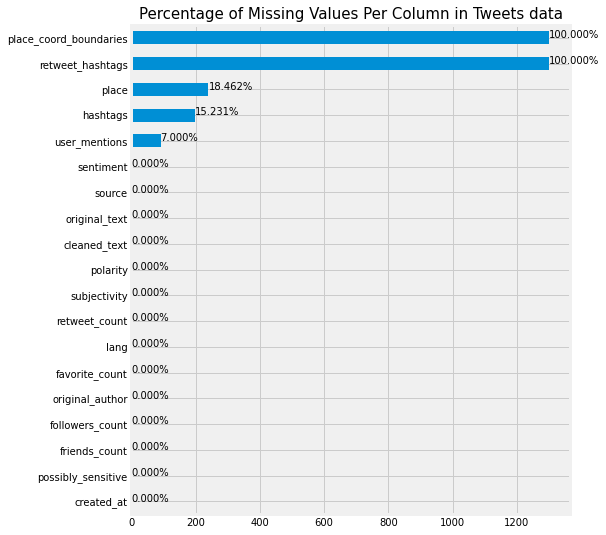

In [13]:
# Check the percentage of missing values in every column
ax = df_tweet.isna().sum().sort_values().plot(kind = 'barh', figsize = (7, 9))
plt.title('Percentage of Missing Values Per Column in Tweets data', fontdict={'size':15})

for p in ax.patches:
    percentage ='{:,.3f}%'.format((p.get_width()/df_tweet.shape[0])*100)
    width, height =p.get_width(),p.get_height()
    x=p.get_x()+width+0.02
    y=p.get_y()+height/2
    ax.annotate(percentage,(x,y))

<AxesSubplot:ylabel='Place'>

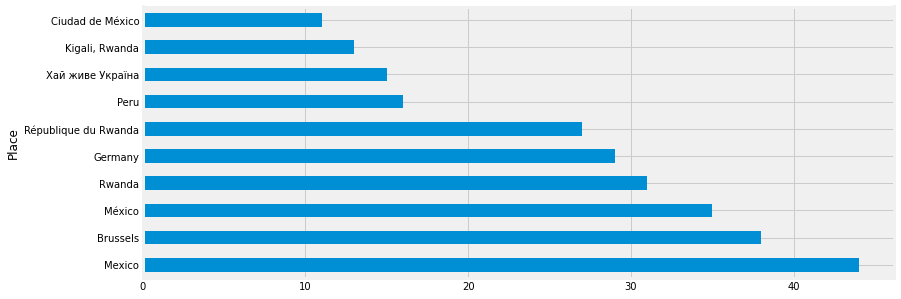

In [14]:
df_tweet['place'].value_counts(sort=True, ascending=False)[:10].plot(kind='barh',
                                                                     figsize=(12,5),xlabel='Place')

In [15]:
df_tweet_date=df_tweet.set_index('created_at')

<AxesSubplot:xlabel='Date,time'>

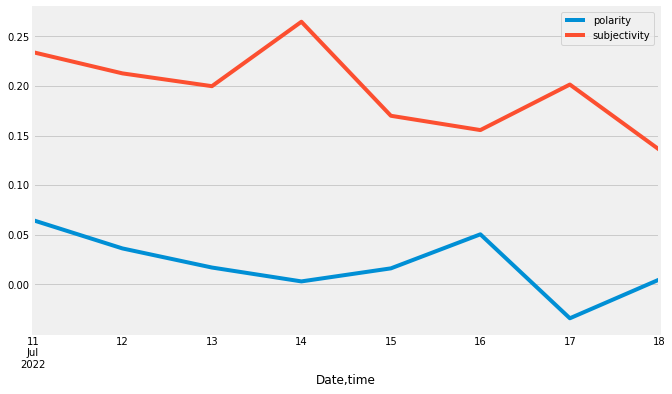

In [16]:
df_tweet_date.resample('D').mean()[['polarity','subjectivity']].dropna().plot(figsize=(10,6),xlabel='Date,time')

### uni-variate Analysis on Hashtags


In [17]:
hashtag_df=df_tweet[['original_text','hashtags','retweet_hashtags']]

In [18]:
def find_hashtags(df_tweet):
    '''This function will extract hashtags'''
    return re.findall('(#[A-Za-z]+[A-Za-z0-9-_]+)', df_tweet)

hashtag_df['hashtag_check']=df_tweet.original_text.apply(find_hashtags)

In [19]:
hashtag_df.dropna(subset=['hashtag_check'],inplace=True)

In [20]:
tags_list=list(hashtag_df['hashtag_check'])

In [21]:
hashtags_list_df = pd.DataFrame([tag for tags_row in tags_list for tag in tags_row],columns=['hashtag'])

In [22]:
hashtags_list_df

,hashtag
0,#M23
1,#DRC
2,#KnowledgeGraphs
3,#abdsc
4,#Semantic
...,...
648,#talks
649,#RDF
650,#Majorit
651,#RDF


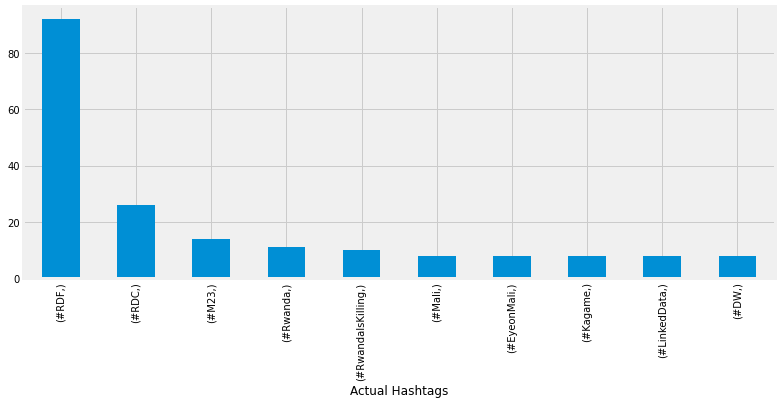

In [23]:
_=hashtags_list_df.value_counts()[:10].plot(kind='bar',figsize=(12,5),xlabel='Actual Hashtags')

In [24]:
#Convert hastags to lowercase
hashtags_list_df['hashtag'] = hashtags_list_df['hashtag'].str.lower()

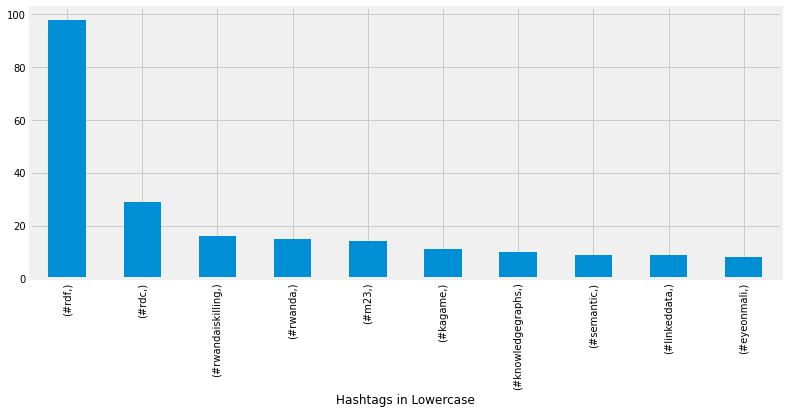

In [25]:
_=hashtags_list_df.value_counts()[:10].plot(kind='bar',figsize=(12,5),xlabel='Hashtags in Lowercase')

In [26]:
user_summary=df_tweet.groupby('original_author').agg({'cleaned_text':'count','followers_count':'max',
                                         'polarity':'mean','subjectivity':'mean', 'sentiment':pd.Series.mode})

In [28]:
user_summary.sort_values(by='cleaned_text',ascending=False).head(10)

,cleaned_text,followers_count,polarity,subjectivity,sentiment
original_author,,,,,
123_INFO_DE,104,118,0.014159,0.160550,Neutral
EUwatchers,94,25730,-0.042728,0.196530,Neutral
Noticieros_MEX,82,4915,-0.031084,0.225005,Neutral
rogue_corq,77,1834,-0.029494,0.226391,Neutral
EtudesRwanda,38,500,0.000000,0.000000,Neutral
bouche_bee,25,2836,0.041667,0.138667,Neutral
SMARFreedom,15,2390,-0.017273,0.166970,Neutral
East_DRC_News,15,1262,0.000000,0.000000,Neutral
acute_tomato,14,17388,-0.036905,0.198810,Neutral


Sentiment summary of the tweets

In [29]:
text_grouped = df_tweet.groupby('sentiment').count()['cleaned_text'].reset_index()

In [30]:
text_grouped

,sentiment,cleaned_text
0,Negative,186
1,Neutral,817
2,Positive,297


<AxesSubplot:xlabel='sentiment', ylabel='count'>

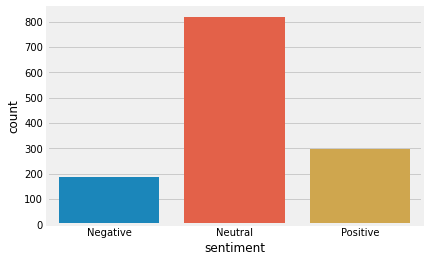

In [31]:
sns.countplot(x='sentiment', data=df_tweet)

**Most frequent words in our tweets dataset**

In [32]:
english_tweets=cleaner.remove_non_english_tweets(df_tweet)

In [33]:
# text Preprocessing
english_tweets['cleaned_text'] = english_tweets['cleaned_text'].str.lower()
english_tweets['cleaned_text'] = english_tweets['cleaned_text'].apply(
    lambda x: x.translate(str.maketrans('', '', string.punctuation)))

In [34]:
all_words=' '.join(english_tweets.cleaned_text.values)
wordcloud_obj=WordCloud(width=1000,height=600,stopwords=STOPWORDS).generate(all_words)

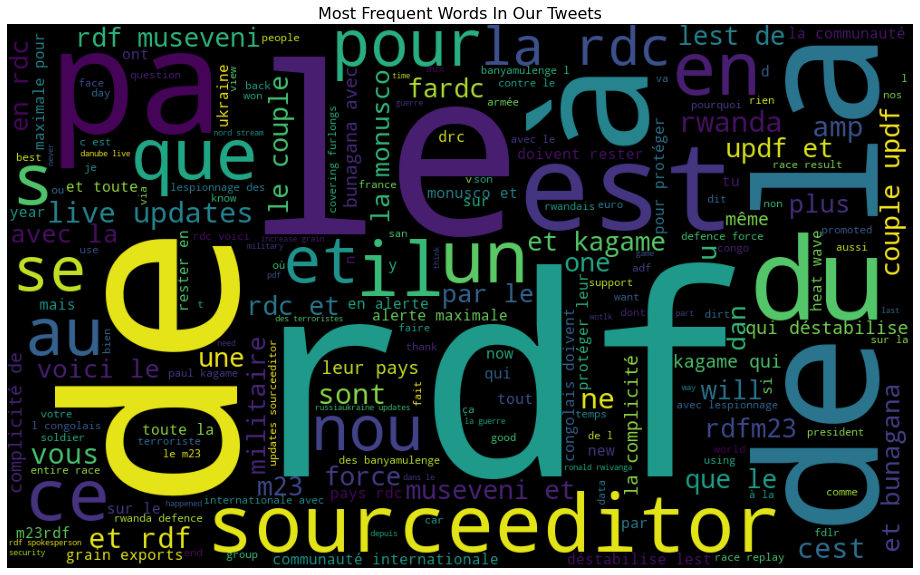

In [35]:
plt.figure(figsize=(20, 10))

plt.imshow(wordcloud_obj)
plt.axis('off')
plt.title('Most Frequent Words In Our Tweets',fontsize=16)
plt.show()

### Topic modeling

In [36]:
def preprocess_data(tweets_df):
    # Converting tweets to list of words For feature engineering
    sentence_list = [tweet for tweet in tweets_df['cleaned_text']]
    word_list = [sent.split() for sent in sentence_list]
    #Save only words and excludes emojis, punctuations
    word_list_new=[]
    for sent in word_list:
        word_list_new.append([re.split(r'\W+',word) for word in sent if word not in STOPWORDS and not word.isdigit()])
    
    word_list_final=[]
    for sent in word_list_new:
        word_list_final.append([i[0] for i in sent])
    # Create dictionary which contains Id and word 
    word_to_id = corpora.Dictionary(word_list_final)
    corpus_1 = [word_to_id.doc2bow(tweet) for tweet in word_list_final]

    return word_list_final, word_to_id, corpus_1

In [37]:
word_list, id2word, corpus=preprocess_data(english_tweets)

In [38]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=False)

In [39]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('rdf', 0.033602066),
   ('will', 0.008779139),
   ('gas', 0.006593626),
   ('one', 0.0063602105),
   ('years', 0.005816978),
   ('dont', 0.004696356),
   ('sourceeditor', 0.004684159),
   ('germany', 0.0046404367),
   ('think', 0.0042364863),
   ('fight', 0.0041160183)]),
 (1,
  [('', 0.029357411),
   ('ukraine', 0.029134681),
   ('sourceeditor', 0.015799891),
   ('rdf', 0.015607003),
   ('live', 0.015239346),
   ('updates', 0.014841897),
   ('russia', 0.01449125),
   ('grain', 0.011610604),
   ('rwanda', 0.011255159),
   ('eu', 0.010259457)]),
 (2,
  [('de', 0.03576859),
   ('la', 0.029438207),
   ('les', 0.029108714),
   ('et', 0.024976838),
   ('le', 0.02354623),
   ('rdf', 0.01780999),
   ('des', 0.015777264),
   ('en', 0.011739604),
   ('à', 0.011714329),
   ('que', 0.011628236)]),
 (3,
  [('', 0.060638327),
   ('rdf', 0.026412163),
   ('amp', 0.018225364),
   ('race', 0.00904654),
   ('forces', 0.007587244),
   ('new', 0.0067714206),
   ('rwivanga', 0.0059842947),
   ('f

### Model Analysis

In [40]:
# Compute Perplexity

#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -7.610057213830577

 Ldamodel Coherence Score/Accuracy on Tweets:  0.5380230930840861


**Model 1 words with some digits, 5 topics**

Perplexity:  -9.857909007134007\
Ldamodel Coherence Score/Accuracy on Tweets:  0.4242327533406264

**Model 2 words without digits, 5 topics**

Perplexity:  -9.82031321033761\
Ldamodel Coherence Score/Accuracy on Tweets:  0.4368570452021986

In [41]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.315110 -0.010984       1        1  48.409577
1      0.076551  0.227110       2        1  15.102557
0      0.103763 -0.148153       3        1  13.092974
3      0.057263  0.010052       4        1  11.746230
4      0.077534 -0.078025       5        1  11.648661, topic_info=             Term        Freq       Total Category  logprob  loglift
0                  317.000000  317.000000  Default  30.0000  30.0000
127            de  340.000000  340.000000  Default  29.0000  29.0000
133            la  280.000000  280.000000  Default  28.0000  28.0000
120           les  277.000000  277.000000  Default  27.0000  27.0000
128            et  238.000000  238.000000  Default  26.0000  26.0000
..            ...         ...         ...      ...      ...      ...
457            uk   14.474906   21.105839   Topic5  -5.0633   1.7728
268          data    9.820066   12.502713   Topic5  -5.4513   1.9085
31            rdf   51.258096  414.367696   Topic5  -3.7989   0.0601
352            us   11.026199   25.024909   Topic5  -5.3355   1.3304
21   sourceeditor   12.376689   74.933895   Topic5  -5.2199   0.3492

[213 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
0         1  0.283601           
0         2  0.274148           
0         4  0.441158           
838       3  0.908129   actually
4336      4  0.909435        aid
...     ...       ...        ...
14        3  0.962929      years
854       3  0.876624        yes
1509      3  0.867392        yet
2954      2  0.985313  zelenskyy
223       1  0.991340          à

[204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1, 4, 5])

**Number of Topics optimatization**

As we can see the coherence accuracy increases with number of topics which is expected but again \
many topics again would lead to meaningless conclusion. Let's use elbow method to find optimum number of topics

In [42]:
# Find best LDA Model considering different number of topics

params_dic={'topics_number':[],'coherence':[],'perplexity':[]}
for top_number in range(1,10):
    lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                            id2word=id2word,
                                            num_topics=top_number, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=False)
    
    perplexity=lda_model.log_perplexity(corpus)  
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    params_dic['topics_number'].append(top_number)
    params_dic['coherence'].append(coherence_lda)
    params_dic['perplexity'].append(perplexity)

<AxesSubplot:>

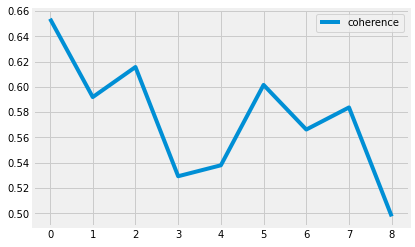

In [43]:
pd.DataFrame(params_dic).plot(y=['coherence'])
# pd.read_csv("elbow_metrics.csv",index_col=0).plot(y=['coherence'])

In [74]:
import numpy as np

In [75]:
alphas = list(np.arange(0.01, 3, 0.1))
alphas.append('symmetric')
alphas.append('asymmetric')
alphas.append('auto')

In [76]:
# Find best LDA Model considering different number of alpha

params_dic_alpha={'alpha':[],'coherence':[],'perplexity':[]}
for alpha in alphas:
    lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                            id2word=id2word,
                                            num_topics=7, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha=alpha,
                                            per_word_topics=False)
    
    perplexity=lda_model.log_perplexity(corpus)  
    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    params_dic_alpha['alpha'].append(alpha)
    params_dic_alpha['coherence'].append(coherence_lda)
    params_dic_alpha['perplexity'].append(perplexity)

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(params_dic_alpha).plot(y='coherence')#.sort_values('coherence',ascending=False)

**Model with selected optimum parameters**

In [32]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus,
                                           id2word=id2word,
                                           num_topics=7, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.1,
                                           per_word_topics=False)

In [33]:
pprint(lda_model.show_topics(formatted=False))

[(0,
  [('people', 0.0325701),
   ('police', 0.014419357),
   ('years', 0.0140809985),
   ('india', 0.010431321),
   ('next', 0.008628952),
   ('love', 0.008419314),
   ('min', 0.0083213635),
   ('week', 0.007926616),
   ('say', 0.007884914),
   ('trading', 0.007446276)]),
 (1,
  [('', 0.22066233),
   ('amp', 0.027856585),
   ('india', 0.013226197),
   ('read', 0.01299347),
   ('man', 0.011259497),
   ('online', 0.010628356),
   ('know', 0.010328608),
   ('minister', 0.008926472),
   ('make', 0.008559865),
   ('says', 0.008314659)]),
 (2,
  [('profile', 0.016618228),
   ('government', 0.013948666),
   ('india', 0.013816173),
   ('may', 0.011332297),
   ('many', 0.010281251),
   ('think', 0.00988554),
   ('price', 0.009602455),
   ('life', 0.008924446),
   ('delhi', 0.008749332),
   ('public', 0.008379177)]),
 (3,
  [('back', 0.027606439),
   ('full', 0.017935673),
   ('sec', 0.017696962),
   ('going', 0.011767578),
   ('state', 0.011052941),
   ('govt', 0.009385832),
   ('national', 0.

In [34]:
# Compute Perplexity
#It's a measure of how good the model is. The lower the better. Perplexity is a negative value
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  
# doc_lda = lda_model[corpus]

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=word_list, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\n Ldamodel Coherence Score/Accuracy on Tweets: ', coherence_lda)


Perplexity:  -10.320856343029874

 Ldamodel Coherence Score/Accuracy on Tweets:  0.46320234284554296


In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.360779 -0.095832       1        1  20.868507
6      0.130121 -0.274320       2        1  15.101335
2     -0.000891  0.143542       3        1  13.097343
0      0.013786  0.080519       4        1  13.030381
4      0.044404  0.136064       5        1  12.898644
5      0.049053  0.095007       6        1  12.535304
3      0.124306 -0.084981       7        1  12.468486, topic_info=         Term         Freq        Total Category  logprob  loglift
0              6573.000000  6573.000000  Default  30.0000  30.0000
133    follow   771.000000   771.000000  Default  29.0000  29.0000
55        one   712.000000   712.000000  Default  28.0000  28.0000
682       amp   830.000000   830.000000  Default  27.0000  27.0000
95       will   885.000000   885.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
447    family    80.759190    81.638241   Topic7  -5.3954   2.0711
928      debt    76.013718    76.899775   Topic7  -5.4559   2.0704
20948   jehan    97.299628    98.785996   Topic7  -5.2090   2.0668
79        now   146.879346   502.926891   Topic7  -4.7972   0.8511
95       will   163.863327   885.229504   Topic7  -4.6878   0.3952

[258 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
0         1  0.999848         
464       1  0.992713        a
2281      1  0.995349   across
1196      2  0.995018   always
787       6  0.990315    among
...     ...       ...      ...
1074      7  0.988986  working
76        5  0.996115    world
31        5  0.992939     year
42        4  0.997079    years
37        3  0.994092      yet

[240 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 3, 1, 5, 6, 4])